In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test/9273.png
/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test/9292.png
/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test/4353.png
/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test/7968.png
/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test/6490.png
/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test/5511.png
/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test/6262.png
/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test/2664.png
/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test/8

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from random import shuffle
import random as rn
import plotly.subplots as sp
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop, Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, confusion_matrix,
    roc_curve, roc_auc_score
)
from sklearn.preprocessing import LabelEncoder


In [4]:

data_dir = '/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/train'
image_size = (100, 100) 

img_width = 180
img_height = 180
batch_size = 64
num_classes = 65
epochs = 10

#standardization and data augmentation to bring all features to a similar scale and range
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
    
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)


labels_dict = {class_name: label for label, class_name in train_generator.class_indices.items()}
print(labels_dict)

Found 42559 images belonging to 65 classes.
Found 0 images belonging to 65 classes.
{0: '0', 1: '1', 2: '10', 3: '11', 4: '12', 5: '13', 6: '14', 7: '15', 8: '16', 9: '17', 10: '18', 11: '19', 12: '2', 13: '20', 14: '21', 15: '22', 16: '23', 17: '24', 18: '25', 19: '26', 20: '27', 21: '28', 22: '29', 23: '3', 24: '30', 25: '31', 26: '32', 27: '33', 28: '34', 29: '35', 30: '36', 31: '37', 32: '38', 33: '39', 34: '4', 35: '40', 36: '41', 37: '42', 38: '43', 39: '44', 40: '45', 41: '46', 42: '47', 43: '48', 44: '49', 45: '5', 46: '50', 47: '51', 48: '52', 49: '53', 50: '54', 51: '55', 52: '56', 53: '57', 54: '58', 55: '59', 56: '6', 57: '60', 58: '61', 59: '62', 60: '63', 61: '64', 62: '7', 63: '8', 64: '9'}


In [5]:
def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the image size and batch size
image_size = (100, 100)
batch_size = 64

# Generate the train and validation datasets
train_ds = image_dataset_from_directory(
    "/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = image_dataset_from_directory(
    "/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 42559 files belonging to 65 classes.
Using 34048 files for training.
Found 42559 files belonging to 65 classes.
Using 8511 files for validation.


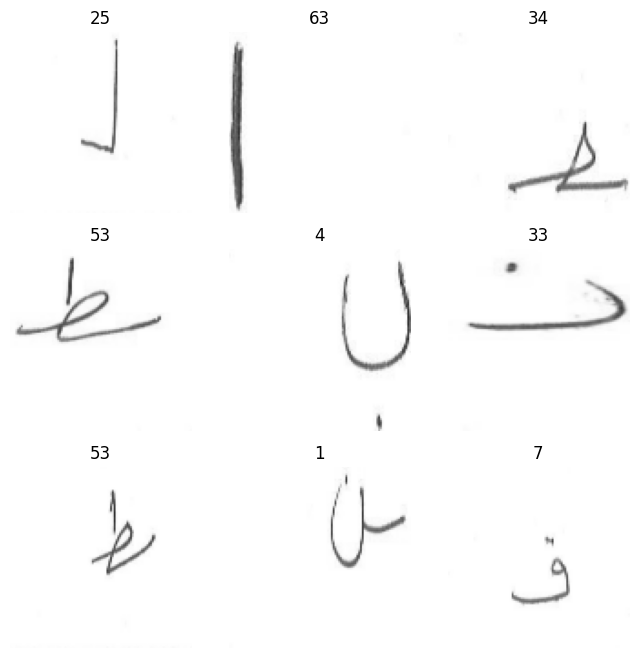

In [7]:
#visualizing a few samples
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

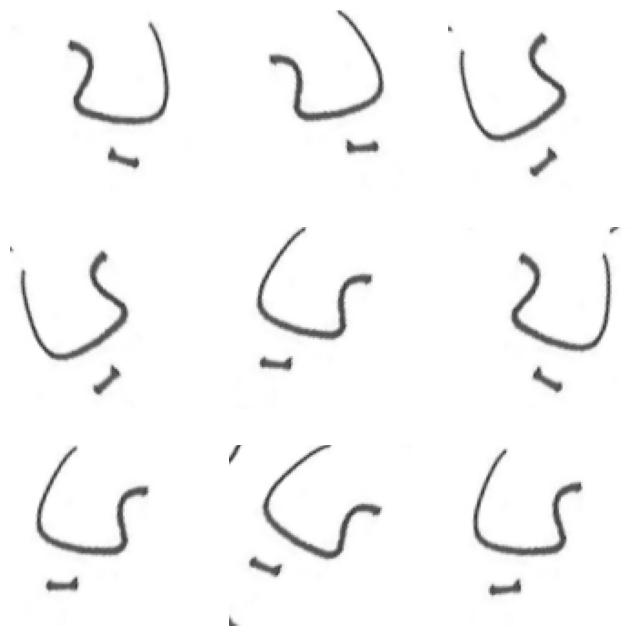

In [8]:
#visualizing few samples after data augmentation
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')  # Adjust output units based on the number of classes
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 128)       0

In [11]:
# Fit the model to your training data
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=8,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/8
664/664 [==============================] - 430s 645ms/step - loss: 4.0155 - accuracy: 0.0438
Epoch 2/8
664/664 [==============================] - 424s 639ms/step - loss: 1.7940 - accuracy: 0.4813
Epoch 3/8
664/664 [==============================] - 424s 638ms/step - loss: 1.0379 - accuracy: 0.6860
Epoch 4/8
664/664 [==============================] - 424s 638ms/step - loss: 0.7460 - accuracy: 0.7702
Epoch 5/8
664/664 [==============================] - 425s 640ms/step - loss: 0.5784 - accuracy: 0.8217
Epoch 6/8
664/664 [==============================] - 425s 639ms/step - loss: 0.4498 - accuracy: 0.8604
Epoch 7/8
664/664 [==============================] - 423s 637ms/step - loss: 0.3576 - accuracy: 0.8877
Epoch 8/8
664/664 [==============================] - 426s 642ms/step - loss: 0.2910 - accuracy: 0.9074


In [12]:
# Save the trained model
model.save("arabic_handwriting_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


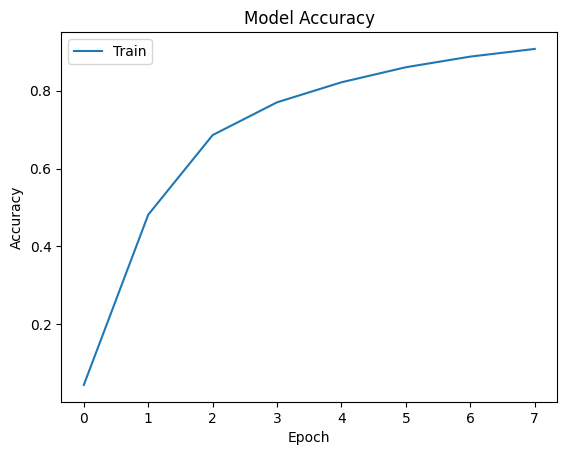

In [13]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')
plt.show()


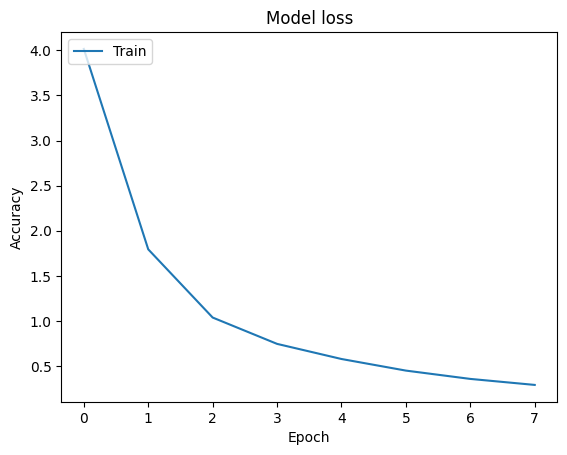

In [14]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')
plt.show()


In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os

# Load the trained model
model = load_model('arabic_handwriting_model.h5')  # Replace with the actual path

# Path to your test directory
test_dir = '/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test'

# Get all image filenames in the test directory
test_images = os.listdir(test_dir)

# Process only the first 20 images
num_images_to_process = 20
counter = 0

for img_name in test_images:
    if counter >= num_images_to_process:
        break

    img_path = os.path.join(test_dir, img_name)
    img = image.load_img(img_path, target_size=(100, 100))  # Load and resize the image
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = img_array.reshape((-1, 100, 100, 3))  # Reshape to match the model's input shape

    # Perform prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)  # Get the index with the highest probability

    # Print the predicted class for each image
    print(f"Image: {img_name}, Predicted Class Index: {predicted_class}")

    counter += 1



1/1 [==============================] - 0s 111ms/step
Image: 9273.png, Predicted Class Index: 56
1/1 [==============================] - 0s 33ms/step
Image: 9292.png, Predicted Class Index: 56
1/1 [==============================] - 0s 33ms/step
Image: 4353.png, Predicted Class Index: 14
1/1 [==============================] - 0s 32ms/step
Image: 7968.png, Predicted Class Index: 48
1/1 [==============================] - 0s 34ms/step
Image: 6490.png, Predicted Class Index: 39
1/1 [==============================] - 0s 35ms/step
Image: 5511.png, Predicted Class Index: 33
1/1 [==============================] - 0s 31ms/step
Image: 6262.png, Predicted Class Index: 8
1/1 [==============================] - 0s 32ms/step
Image: 2664.png, Predicted Class Index: 7
1/1 [==============================] - 0s 32ms/step
Image: 8419.png, Predicted Class Index: 51
1/1 [==============================] - 0s 30ms/step
Image: 9703.png, Predicted Class Index: 59
1/1 [==============================] - 0s 33ms/step

1/1 [==============================] - 0s 30ms/step


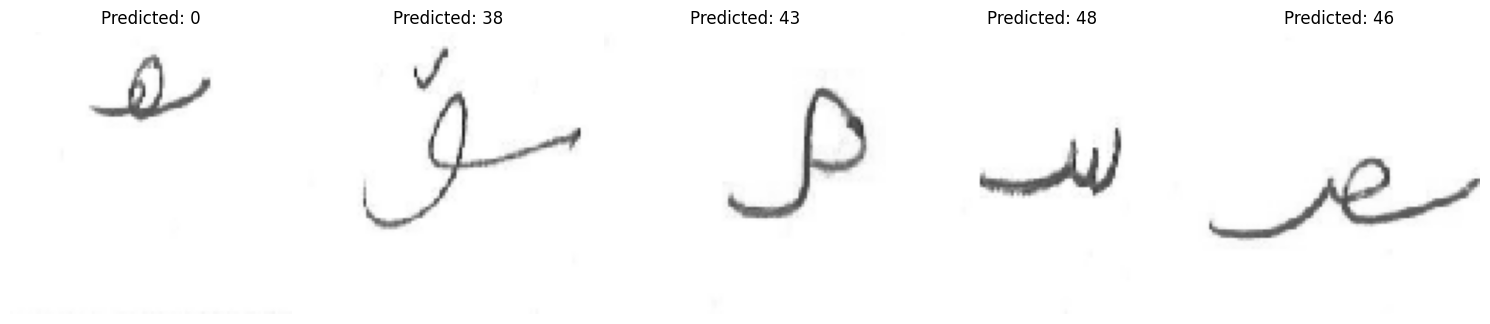

In [19]:
import matplotlib.pyplot as plt
import random

# Function to visualize predicted images
def visualize_predicted_images(model, test_dir, num_images=5):
    # Get all image filenames in the test directory
    test_images = os.listdir(test_dir)

    # Select random images for visualization
    random_images = random.sample(test_images, num_images)

    plt.figure(figsize=(15, 8))
    for i, img_name in enumerate(random_images, 1):
        img_path = os.path.join(test_dir, img_name)
        img = image.load_img(img_path, target_size=(100, 100))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0
        img_array = img_array.reshape((-1, 100, 100, 3))

        # Perform prediction
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions)

        plt.subplot(1, num_images, i)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage: visualize some random predicted images
visualize_predicted_images(model, test_dir)


In [21]:
import csv

# Assuming 'validation_generator' is your validation data generator

# Open a CSV file in write mode
with open('predicted_labels.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'Label'])

    image_counter = 0

    for i in range(len(validation_generator)):
        batch_images, batch_labels = validation_generator[i]
        predictions = model.predict(batch_images)
        
        for j in range(len(batch_labels)):
            predicted_label = np.argmax(predictions[j])
            
            writer.writerow([image_counter, predicted_label])
            image_counter += 1  # Incrementing the image number
